In [ ]:
import mat73
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.utils import plot_model, to_categorical


## Data Loading and Processing

In [ ]:
import os

DATA_DIR = ''
if 'google.colab' not in str(get_ipython()) and "anuja" in os.environ.get('USER'):
    DATA_DIR = 'data/'


In [ ]:
# data loading
data = mat73.loadmat(DATA_DIR+'x_source.mat')  
print(data['x'].shape) 
columns = np.asarray([['Electrode %d - %d/2 Hz'%(i+1, j+1)] for i in range(data['x'].shape[1]) for j in range(data['x'].shape[2])])
labels = pd.read_csv(DATA_DIR+"table_withlabels.csv")
foof = pd.read_csv(DATA_DIR+"foof2features.csv")
beh = pd.read_csv(DATA_DIR+"behaviorals.csv")
df = pd.DataFrame(data['x'].reshape((data['x'].shape[0], -1)))
df.columns = columns
df['IDs'] = foof['C1']
df = pd.merge(df, labels[['label', 'IDs']], on='IDs', how='inner')
print(df['label'].value_counts())

(2041, 68, 391)
Other Neurodevelopmental Disorders    492
ADHD-Inattentive Type                 387
ADHD-Combined Type                    376
Anxiety Disorders                     241
No Diagnosis Given                    203
Depressive Disorders                   85
Name: label, dtype: int64


In [ ]:
# add labels
pd.options.mode.chained_assignment = None

df.label[df.label == 'Other Neurodevelopmental Disorders'] = 1
df.label[df.label == 'ADHD-Inattentive Type'] = 2
df.label[df.label == 'ADHD-Combined Type'] = 3
df.label[df.label == 'Anxiety Disorders'] = 4
df.label[df.label == 'No Diagnosis Given'] = 5
df.label[df.label == 'Depressive Disorders'] = 6
df.label = df['label'].astype(int)
labels = ['Other Neurodevelopmental Disorders', 'ADHD-Inattentive Type', 'ADHD-Combined Type', 'Anxiety Disorders', 'No Diagnosis Given', 'Depressive Disorders']

In [ ]:
df

,"(Electrode 1 - 1/2 Hz,)","(Electrode 1 - 2/2 Hz,)","(Electrode 1 - 3/2 Hz,)","(Electrode 1 - 4/2 Hz,)","(Electrode 1 - 5/2 Hz,)","(Electrode 1 - 6/2 Hz,)","(Electrode 1 - 7/2 Hz,)","(Electrode 1 - 8/2 Hz,)","(Electrode 1 - 9/2 Hz,)","(Electrode 1 - 10/2 Hz,)","(Electrode 1 - 11/2 Hz,)","(Electrode 1 - 12/2 Hz,)","(Electrode 1 - 13/2 Hz,)","(Electrode 1 - 14/2 Hz,)","(Electrode 1 - 15/2 Hz,)","(Electrode 1 - 16/2 Hz,)","(Electrode 1 - 17/2 Hz,)","(Electrode 1 - 18/2 Hz,)","(Electrode 1 - 19/2 Hz,)","(Electrode 1 - 20/2 Hz,)","(Electrode 1 - 21/2 Hz,)","(Electrode 1 - 22/2 Hz,)","(Electrode 1 - 23/2 Hz,)","(Electrode 1 - 24/2 Hz,)","(Electrode 1 - 25/2 Hz,)","(Electrode 1 - 26/2 Hz,)","(Electrode 1 - 27/2 Hz,)","(Electrode 1 - 28/2 Hz,)","(Electrode 1 - 29/2 Hz,)","(Electrode 1 - 30/2 Hz,)","(Electrode 1 - 31/2 Hz,)","(Electrode 1 - 32/2 Hz,)","(Electrode 1 - 33/2 Hz,)","(Electrode 1 - 34/2 Hz,)","(Electrode 1 - 35/2 Hz,)","(Electrode 1 - 36/2 Hz,)","(Electrode 1 - 37/2 Hz,)","(Electrode 1 - 38/2 Hz,)","(Electrode 1 - 39/2 Hz,)","(Electrode 1 - 40/2 Hz,)",...,"(Electrode 68 - 354/2 Hz,)","(Electrode 68 - 355/2 Hz,)","(Electrode 68 - 356/2 Hz,)","(Electrode 68 - 357/2 Hz,)","(Electrode 68 - 358/2 Hz,)","(Electrode 68 - 359/2 Hz,)","(Electrode 68 - 360/2 Hz,)","(Electrode 68 - 361/2 Hz,)","(Electrode 68 - 362/2 Hz,)","(Electrode 68 - 363/2 Hz,)","(Electrode 68 - 364/2 Hz,)","(Electrode 68 - 365/2 Hz,)","(Electrode 68 - 366/2 Hz,)","(Electrode 68 - 367/2 Hz,)","(Electrode 68 - 368/2 Hz,)","(Electrode 68 - 369/2 Hz,)","(Electrode 68 - 370/2 Hz,)","(Electrode 68 - 371/2 Hz,)","(Electrode 68 - 372/2 Hz,)","(Electrode 68 - 373/2 Hz,)","(Electrode 68 - 374/2 Hz,)","(Electrode 68 - 375/2 Hz,)","(Electrode 68 - 376/2 Hz,)","(Electrode 68 - 377/2 Hz,)","(Electrode 68 - 378/2 Hz,)","(Electrode 68 - 379/2 Hz,)","(Electrode 68 - 380/2 Hz,)","(Electrode 68 - 381/2 Hz,)","(Electrode 68 - 382/2 Hz,)","(Electrode 68 - 383/2 Hz,)","(Electrode 68 - 384/2 Hz,)","(Electrode 68 - 385/2 Hz,)","(Electrode 68 - 386/2 Hz,)","(Electrode 68 - 387/2 Hz,)","(Electrode 68 - 388/2 Hz,)","(Electrode 68 - 389/2 Hz,)","(Electrode 68 - 390/2 Hz,)","(Electrode 68 - 391/2 Hz,)",IDs,label
0,5.078868e-01,5.217506e-01,5.333599e-01,5.438772e-01,5.520926e-01,5.588265e-01,5.634961e-01,5.659676e-01,5.664875e-01,5.649957e-01,5.613439e-01,5.555999e-01,5.482868e-01,5.386750e-01,5.278712e-01,5.147946e-01,5.001387e-01,4.849380e-01,4.676623e-01,4.502855e-01,4.310493e-01,4.110748e-01,3.916367e-01,3.707484e-01,3.507655e-01,3.296295e-01,3.086076e-01,2.889369e-01,2.685895e-01,2.499353e-01,2.315197e-01,2.162914e-01,2.093246e-01,2.200712e-01,2.627575e-01,3.596749e-01,5.141251e-01,6.890813e-01,8.456770e-01,9.064507e-01,...,0.389905,0.384912,0.379682,0.374895,0.371872,0.373132,0.383549,0.411604,0.462666,0.528958,0.600496,0.644823,0.644964,0.594720,0.518241,0.434165,0.370044,0.325096,0.299301,0.285569,0.276460,0.269846,0.263554,0.257467,0.251762,0.245778,0.240142,0.234232,0.228365,0.222850,0.217079,0.211663,0.206002,0.200403,0.195159,0.189689,0.184573,0.179243,NDARAA075AMK,5
1,1.318260e+00,1.346233e+00,1.346461e+00,1.319271e+00,1.277007e+00,1.202095e+00,1.108148e+00,1.024186e+00,9.160927e-01,8.353658e-01,7.587729e-01,7.367982e-01,7.797584e-01,9.192535e-01,1.078998e+00,1.267459e+00,1.346500e+00,1.290148e+00,1.092640e+00,8.907423e-01,6.670004e-01,5.265084e-01,4.770403e-01,4.722646e-01,4.957937e-01,5.418631e-01,5.957864e-01,6.405335e-01,6.954713e-01,7.368590e-01,7.832306e-01,8.214662e-01,8.448543e-01,8.638256e-01,8.702151e-01,8.669866e-01,8.516976e-01,8.314959e-01,7.976543e-01,7.649895e-01,...,0.541578,0.569372,0.600170,0.619676,0.623796,0.612853,0.591631,0.551993,0.502159,0.458681,0.404575,0.364665,0.322408,0.291153,0.274995,0.265953,0.267121,0.277817,0.296977,0.316994,0.346111,0.371433,0.404070,0.436245,0.460649,0.488388,0.507659,0.527295,0.541281,0.548031,0.550646,0.548010,0.538900,0.523634,0.507341,0.482457,0.459452,0.427597,NDARAA112DMH,3
2,3.202934e-01,3.261972e-01,3.312618e-01,3.371

In [ ]:
# data splitting

train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['label'])

train_labels, test_labels = train_df['label'], test_df['label']
test_labels_categorical = to_categorical(test_df['label']-1)

train_features = train_df[train_df.columns.difference(['IDs', 'label'])]
test_features = test_df[test_df.columns.difference(['IDs', 'label'])]

## AutoEncoder for Feature Extraction

In [ ]:
# not enough GPU RAM for this

# n_inputs = train_features.shape[1]

# visible = Input(shape=(n_inputs,))
# e = Dense(n_inputs*2)(visible)
# e = BatchNormalization()(e)
# e = LeakyReLU()(e)
# e = Dense(n_inputs)(e)
# e = BatchNormalization()(e)
# e = LeakyReLU()(e)
# n_bottleneck = round(float(n_inputs) / 2.0)
# bottleneck = Dense(n_bottleneck)(e)

# d = Dense(n_inputs)(bottleneck)
# d = BatchNormalization()(d)
# d = LeakyReLU()(d)

# d = Dense(n_inputs*2)(d)
# d = BatchNormalization()(d)
# d = LeakyReLU()(d)

# output = Dense(n_inputs, activation='linear')(d)

# model = Model(inputs=visible, outputs=output)
# model.compile(optimizer='adam', loss='mse')
# plot_model(model, 'autoencoder_compress.png', show_shapes=True)

# history = model.fit(train_features, train_labels, epochs=15, batch_size=8, verbose=2)
# encoder = Model(inputs=visible, outputs=bottleneck)

# plot_model(encoder, 'encoder_compress.png', show_shapes=True)
# encoder.save('autoencoder.h5')

ResourceExhaustedError: ignored

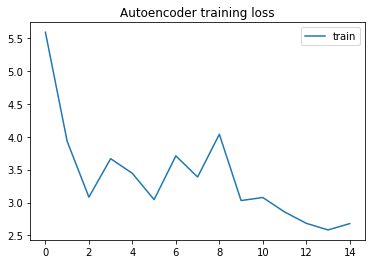

In [ ]:
  # # plot loss
  # plt.plot(history.history['loss'], label='train')
  # plt.title('Autoencoder training loss')
  # plt.legend()
  # plt.show()

In [ ]:
# # encode the data
# encoder= load_model('autoencoder.h5', compile=False)

# train_features_encoded = encoder.predict(train_features)
# test_features_encoded = encoder.predict(test_features)

# until encoder is fixed
train_features_encoded = train_features
test_features_encoded = test_features

## Dealing with imbalance

In [ ]:
oversample = SMOTE()
train_features_encoded_oversampled, train_labels_oversampled = oversample.fit_resample(train_features_encoded, train_labels)
train_features_oversampled, train_labels_oversampled_ = oversample.fit_resample(train_features, train_labels)

train_labels_oversampled_categorical = to_categorical(train_labels_oversampled-1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
if 'google.colab' in str(get_ipython()):
  np.save('train_features_encoded_oversampled.npy', train_features_encoded_oversampled)
  np.save('train_labels_oversampled.npy', train_labels_oversampled)
  np.save('train_features_encoded.npy', train_features_encoded)
  np.save('test_features_encoded.npy', test_features_encoded)

In [ ]:
# scaling the data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_features_encoded_oversampled = scaler.fit_transform(train_features_encoded_oversampled)
test_features_encoded = scaler.transform(test_features_encoded)

train_features_encoded_oversampled = np.clip(train_features_encoded_oversampled, -5, 5)
test_features_encoded = np.clip(test_features_encoded, -5, 5)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
print(train_features_encoded_oversampled.shape)
print(train_labels_oversampled.shape)
print(train_labels_oversampled_categorical.shape)
print(test_features_encoded.shape)
print(test_labels.shape)

(2064, 26588)
(2064,)
(2064, 6)
(536, 26588)
(536,)


## Linear Models

### SVC

In [ ]:
from sklearn import svm

clf = svm.SVC(kernel='linear', verbose=True)
clf.fit(train_features_encoded_oversampled, train_labels_oversampled)

predicted_labels_svc = clf.predict(test_features_encoded)

[LibSVM]

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate(y_test, y_pred, show_cm=True, is_categorical=False):
    
    if is_categorical:
      y_test = np.argmax(y_test, axis=1)
      y_pred = np.argmax(y_pred, axis=1)

    print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
    print("Precision:", metrics.precision_score(y_test, y_pred, average='macro'))
    print("Recall:", metrics.recall_score(y_test, y_pred, average='macro'))
#     print("ROC AUC:", metrics.roc_auc_score(y_test, y_pred, multi_class='ovo',))
    print("F1 score:", metrics.f1_score(y_test, y_pred, average='macro'))
#     print("Brier Score:", metrics.brier_score_loss(y_test, y_pred)) # only for binary classification

    if show_cm:
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot()
        plt.tight_layout()
        plt.show()


Accuracy: 0.22574626865671643
Precision: 0.19645974450602288
Recall: 0.17174094976538237
F1 score: 0.16928043018593952


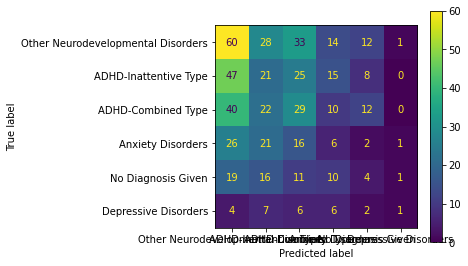

In [ ]:
evaluate(test_labels, predicted_labels_svc)

### OneVsRestClassifier
The strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes.

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

clf = OneVsRestClassifier(LinearSVC(random_state=0, max_iter=2000, verbose=True))

clf.fit(train_features_encoded_oversampled, train_labels_oversampled)
predicted_labels_ovr = clf.predict(test_features_encoded)

[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Accuracy: 0.19776119402985073
Precision: 0.1580972230490225
Recall: 0.16089409168845079
F1 score: 0.1591287822852281


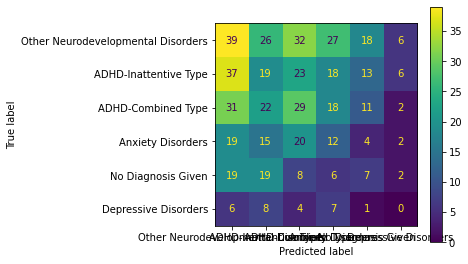

In [ ]:
evaluate(test_labels, predicted_labels_ovr)

### OneVsOneClassifier
OneVsOneClassifier constructs one classifier per pair of classes. At prediction time, the class which received the most votes is selected. In the event of a tie (among two classes with an equal number of votes), it selects the class with the highest aggregate classification confidence by summing over the pair-wise classification confidence levels computed by the underlying binary classifiers.



In [ ]:
from sklearn.multiclass import OneVsOneClassifier

clf = OneVsOneClassifier(LinearSVC(random_state=0, verbose=True))

clf.fit(train_features_encoded_oversampled, train_labels_oversampled)
predicted_labels_ovo = clf.predict(test_features_encoded)

[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Accuracy: 0.19776119402985073
Precision: 0.1580972230490225
Recall: 0.16089409168845079
F1 score: 0.1591287822852281


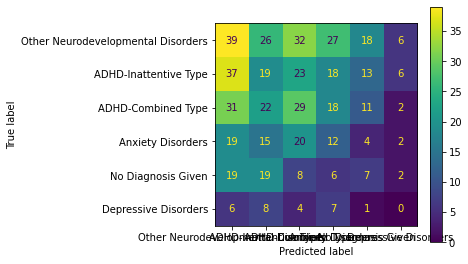

In [ ]:
evaluate(test_labels, predicted_labels_ovr)

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=5, random_state=0, verbose=True)
clf.fit(train_features_encoded_oversampled, train_labels_oversampled)
predicted_labels_rf = clf.predict(test_features_encoded)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   11.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy: 0.208955223880597
Precision: 0.1813615711269433
Recall: 0.18615415067369076
F1 score: 0.17769559854558095


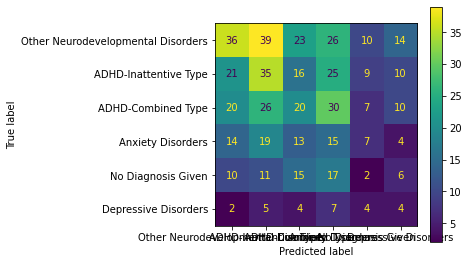

In [ ]:
evaluate(test_labels, predicted_labels_rf)

### MLP


In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1, max_iter=300, verbose=True)
clf.fit(train_features_encoded_oversampled, train_labels_oversampled)
predicted_labels_mlp = clf.predict(test_features_encoded)

Iteration 1, loss = 5.20866221
Iteration 2, loss = 1.61004169
Iteration 3, loss = 0.42391268
Iteration 4, loss = 0.09712927
Iteration 5, loss = 0.02800187
Iteration 6, loss = 0.00993417
Iteration 7, loss = 0.00696715
Iteration 8, loss = 0.00415476
Iteration 9, loss = 0.00084112
Iteration 10, loss = 0.00306692
Iteration 11, loss = 0.00066469
Iteration 12, loss = 0.00056654
Iteration 13, loss = 0.00050010
Iteration 14, loss = 0.00045113
Iteration 15, loss = 0.00041542
Iteration 16, loss = 0.00038837
Iteration 17, loss = 0.00036577
Iteration 18, loss = 0.00034667
Iteration 19, loss = 0.00032964
Iteration 20, loss = 0.00031568
Iteration 21, loss = 0.00030332
Iteration 22, loss = 0.00029210
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


Accuracy: 0.22574626865671643
Precision: 0.2159136033573815
Recall: 0.1897854238362725
F1 score: 0.19467778859272158


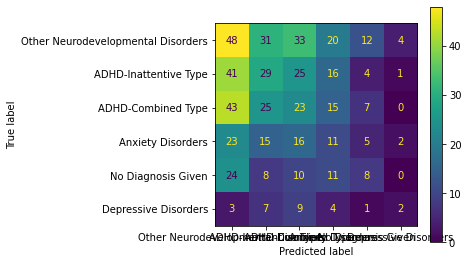

In [ ]:
evaluate(test_labels, predicted_labels_mlp)

## CNNs

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D 
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
# print('Tensorflow Version: ',tensorflow.__version__)
from tensorflow.keras.layers import BatchNormalization

def get_CNN_classifier():
  # Initialising the CNN
  model = Sequential()
  # Convolution
  model.add(Conv1D(filters = 32, kernel_size = 3, input_shape = (391, 68), activation = 'relu', padding = 'same'))
  # Pooling
  model.add(MaxPooling1D(pool_size = 2))
  # Convolution
  model.add(Conv1D(filters = 64, kernel_size = 3, input_shape = (39, 32), activation = 'relu', padding = 'same'))
  model.add(Conv1D(filters = 64, kernel_size = 3, input_shape = (39, 64), activation = 'relu', padding = 'same'))
  model.add(BatchNormalization())
  model.add(MaxPooling1D(pool_size = 2))
  model.add(Conv1D(filters =128, kernel_size = 3, input_shape = (19, 64), activation = 'relu', padding = 'same'))
  # model.add(Conv1D(filters =128, kernel_size = 3, input_shape = (19, 128), activation = 'relu', padding = 'same'))
  model.add(BatchNormalization())
  model.add(MaxPooling1D(pool_size = 2))
  model.add(Conv1D(filters =256, kernel_size = 3, input_shape = (9, 128), activation = 'relu', padding = 'same'))
  #model.add(Conv1D(filters =256, kernel_size = 3, input_shape = (9, 256), activation = 'relu', padding = 'same'))
  model.add(BatchNormalization())
  model.add(MaxPooling1D(pool_size = 2))
  model.add(Conv1D(filters =512, kernel_size = 3, input_shape = (4, 256), activation = 'relu', padding = 'same'))
  #model.add(Conv1D(filters =512, kernel_size = 3, input_shape = (4, 512), activation = 'relu', padding = 'same'))
  model.add(BatchNormalization())
  model.add(MaxPooling1D(pool_size = 2))
  model.add(Conv1D(filters = 1024, kernel_size = 3, input_shape = (2, 512), activation = 'relu', padding = 'same'))
  model.add(Conv1D(filters = 1024, kernel_size = 3, input_shape = (2, 1028), activation = 'relu', padding = 'same'))
  model.add(MaxPooling1D(pool_size = 2))
  # Flattening
  model.add(Flatten())

  model.add(Dense(units = 6, activation = 'softmax'))
  # Compiling the CNN
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
  model.summary()
  
  return model

CNN_model = get_CNN_classifier()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 391, 32)           6560      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 195, 32)          0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 195, 64)           6208      
                                                                 
 conv1d_10 (Conv1D)          (None, 195, 64)           12352     
                                                                 
 batch_normalization_4 (Batc  (None, 195, 64)          256       
 hNormalization)                                                 
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 97, 64)          

In [ ]:
# data reshaping for CNN
n = 68
m = 391

train_features_oversampled_reshaped = train_features_oversampled.to_numpy().reshape((train_features_oversampled.shape[0], n, m))
test_features_reshaped = test_features.to_numpy().reshape((test_features.shape[0], n, m))

In [ ]:
history_CNN = CNN_model.fit(np.transpose(train_features_oversampled_reshaped, (0, 2, 1)), train_labels_oversampled_categorical, validation_split=0.2, epochs=100, verbose=1)

Epoch 1/100
52/52 [==============================] - 20s 34ms/step - loss: 2.4236 - accuracy: 0.2380 - val_loss: 6.3556 - val_accuracy: 0.0000e+00
Epoch 2/100
52/52 [==============================] - 1s 17ms/step - loss: 1.5198 - accuracy: 0.3907 - val_loss: 9.7062 - val_accuracy: 0.3099
Epoch 3/100
52/52 [==============================] - 1s 17ms/step - loss: 1.2340 - accuracy: 0.5294 - val_loss: 9.3515 - val_accuracy: 0.0000e+00
Epoch 4/100
52/52 [==============================] - 1s 16ms/step - loss: 1.0096 - accuracy: 0.6305 - val_loss: 9.6703 - val_accuracy: 0.0194
Epoch 5/100
52/52 [==============================] - 1s 17ms/step - loss: 0.7167 - accuracy: 0.7414 - val_loss: 4.0834 - val_accuracy: 0.2107
Epoch 6/100
52/52 [==============================] - 1s 16ms/step - loss: 0.4281 - accuracy: 0.8365 - val_loss: 4.8732 - val_accuracy: 0.1477
Epoch 7/100
52/52 [==============================] - 1s 17ms/step - loss: 0.3009 - accuracy: 0.8922 - val_loss: 11.7850 - val_accuracy: 0.1

Accuracy: 0.20522388059701493
Precision: 0.14717683451698796
Recall: 0.15606976500555444
F1 score: 0.14933969856832036


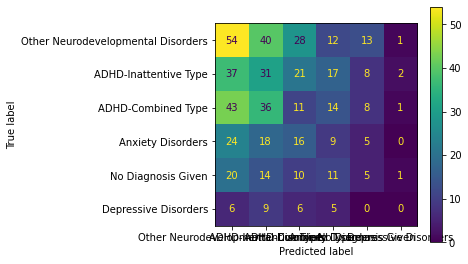

In [ ]:
predicted_labels_cnn = CNN_model.predict(np.transpose(test_features_reshaped, (0, 2, 1)))
evaluate(test_labels_categorical, predicted_labels_cnn, is_categorical=True)

In [ ]:
from tensorflow.keras.layers import Conv2D , MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
#dilation of the filters , for deeper  convolutionm try with the whole signal
def get_CNN_2_classifier():

    k = 3  # kernel size
    s = 2  # stride
    n_filters = 32 # number of filters
    inputs = Input(shape=(m, n, 1))

    conv1 = Conv2D(n_filters, kernel_size=(k, k), strides=(s, s), padding='same')(inputs)
    conv1 = BatchNormalization(scale=False, axis=3)(conv1)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    conv1 = Conv2D(n_filters, kernel_size=(k, k), padding='same')(conv1)
    conv1 = BatchNormalization(scale=False, axis=3)(conv1)
    conv1 = LeakyReLU(alpha=0.1)(conv1)
    pool1 = MaxPooling2D(pool_size=(s, s))(conv1)

    conv2 = Conv2D(2 * n_filters, kernel_size=(k, k), strides=(s, s), padding='same')(pool1)
    conv2 = BatchNormalization(scale=False, axis=3)(conv2)
    conv2 = LeakyReLU(alpha=0.3)(conv2)
    conv2 = Conv2D(2 * n_filters, kernel_size=(k, k), padding='same')(conv2)
    conv2 = BatchNormalization(scale=False, axis=3)(conv2)
    conv2 = LeakyReLU(alpha=0.1)(conv2)
    pool2 = MaxPooling2D(pool_size=(s, s))(conv2)

    conv3 = Conv2D(4 * n_filters, kernel_size=(k, k), padding='same')(pool2)
    conv3 = BatchNormalization(scale=False, axis=3)(conv3)
    conv3 = LeakyReLU(alpha=0.1)(conv3)
    conv3 = Conv2D(4 * n_filters, kernel_size=(k, k), padding='same')(conv3)
    conv3 = BatchNormalization(scale=False, axis=3)(conv3)
    conv3 = LeakyReLU(alpha=0.1)(conv3)
    pool3 = MaxPooling2D(pool_size=(s, s))(conv3)

    conv4 = Conv2D(8 * n_filters, kernel_size=(k, k), padding='same')(pool3)
    conv4 = BatchNormalization(scale=False, axis=3)(conv4)
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    conv4 = Conv2D(8 * n_filters, kernel_size=(k, k), padding='same')(conv4)
    conv4 = BatchNormalization(scale=False, axis=3)(conv4)
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D(pool_size=(s, s))(conv4)

    conv5 = Conv2D(16 * n_filters, kernel_size=(k, k), padding='same')(pool4)
    conv5 = BatchNormalization(scale=False, axis=3)(conv5)
    conv5 = LeakyReLU(alpha=0.1)(conv5)
    conv5 = Conv2D(16 * n_filters, kernel_size=(k, k), padding='same')(conv5)
    conv5 = BatchNormalization(scale=False, axis=3)(conv5)
    conv5 = LeakyReLU(alpha=0.1)(conv5)

    gap = GlobalAveragePooling2D()(conv5)
    outputs = Dense(6, activation='softmax')(gap)

    model = Model(inputs, outputs)
    model.compile(optimizer = Adam(lr=1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    model.summary()
  
    return model

CNN_model_2 = get_CNN_2_classifier()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 391, 68, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 196, 34, 32)       320       
                                                                 
 batch_normalization_8 (Batc  (None, 196, 34, 32)      96        
 hNormalization)                                                 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 196, 34, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 196, 34, 32)       9248      
                                                                 
 batch_normalization_9 (Batc  (None, 196, 34, 32)      96        
 hNormalization)                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history_CNN_2 = CNN_model_2.fit(np.transpose(train_features_oversampled_reshaped, (0, 2, 1)), train_labels_oversampled_categorical, validation_split=0.2, epochs=50, verbose=1)


Epoch 1/50
52/52 [==============================] - 4s 33ms/step - loss: 1.7756 - accuracy: 0.2762 - val_loss: 1.8031 - val_accuracy: 0.0000e+00
Epoch 2/50
52/52 [==============================] - 1s 19ms/step - loss: 0.9274 - accuracy: 0.7341 - val_loss: 1.9764 - val_accuracy: 0.0000e+00
Epoch 3/50
52/52 [==============================] - 1s 19ms/step - loss: 0.3183 - accuracy: 0.9412 - val_loss: 2.6857 - val_accuracy: 0.0000e+00
Epoch 4/50
52/52 [==============================] - 1s 19ms/step - loss: 0.0775 - accuracy: 0.9952 - val_loss: 4.0441 - val_accuracy: 0.0000e+00
Epoch 5/50
52/52 [==============================] - 1s 20ms/step - loss: 0.0235 - accuracy: 0.9988 - val_loss: 4.9560 - val_accuracy: 0.0000e+00
Epoch 6/50
52/52 [==============================] - 1s 19ms/step - loss: 0.0113 - accuracy: 1.0000 - val_loss: 5.5775 - val_accuracy: 0.0073
Epoch 7/50
52/52 [==============================] - 1s 20ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 6.1335 - val_accuracy: 

Accuracy: 0.2462686567164179
Precision: 0.21301707360542835
Recall: 0.20549443646276014
F1 score: 0.20570803229335125


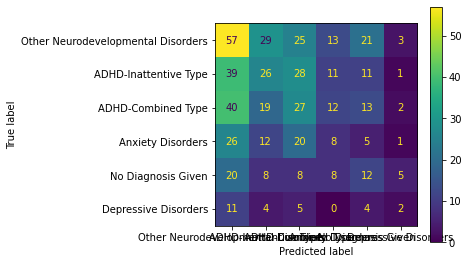

In [ ]:
predicted_labels_cnn_2 = CNN_model_2.predict(np.transpose(test_features_reshaped, (0, 2, 1)))
evaluate(test_labels_categorical, predicted_labels_cnn_2, is_categorical=True)

In [ ]:
def get_CNN_3_classifier():
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(m, n, 1)))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(6, activation='softmax'))

  model.compile(optimizer = Adam(lr=1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  model.summary()

  return model

CNN_model_3 = get_CNN_3_classifier()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 389, 66, 32)       320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 194, 33, 32)      0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 194, 33, 32)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 192, 31, 64)       18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 96, 15, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 96, 15, 64)       

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history_cnn_3 = CNN_model_3.fit(np.transpose(train_features_oversampled_reshaped, (0, 2, 1)), train_labels_oversampled_categorical, validation_split=0.2, epochs=100, verbose=1)

Epoch 1/100
52/52 [==============================] - 2s 26ms/step - loss: 1.7747 - accuracy: 0.2296 - val_loss: 2.2849 - val_accuracy: 0.0000e+00
Epoch 2/100
52/52 [==============================] - 1s 19ms/step - loss: 1.6749 - accuracy: 0.2883 - val_loss: 2.1159 - val_accuracy: 0.0000e+00
Epoch 3/100
52/52 [==============================] - 1s 18ms/step - loss: 1.6440 - accuracy: 0.3041 - val_loss: 2.0312 - val_accuracy: 0.0000e+00
Epoch 4/100
52/52 [==============================] - 1s 19ms/step - loss: 1.6049 - accuracy: 0.3210 - val_loss: 2.0881 - val_accuracy: 0.0000e+00
Epoch 5/100
52/52 [==============================] - 1s 19ms/step - loss: 1.5427 - accuracy: 0.3792 - val_loss: 1.9814 - val_accuracy: 0.0872
Epoch 6/100
52/52 [==============================] - 1s 19ms/step - loss: 1.4650 - accuracy: 0.4204 - val_loss: 1.9015 - val_accuracy: 0.0387
Epoch 7/100
52/52 [==============================] - 1s 19ms/step - loss: 1.4120 - accuracy: 0.4458 - val_loss: 1.8932 - val_accurac

Accuracy: 0.2537313432835821
Precision: 0.18366633007324026
Recall: 0.19087274990221262
F1 score: 0.1817427259290377


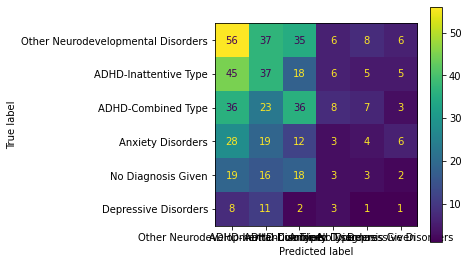

In [ ]:
predicted_labels_cnn_3 = CNN_model_3.predict(np.transpose(test_features_reshaped, (0, 2, 1)))
evaluate(test_labels_categorical, predicted_labels_cnn_3, is_categorical=True)

## Ensemble Learning

In [ ]:
from self_paced_ensemble import SelfPacedEnsembleClassifier

clf = SelfPacedEnsembleClassifier(base_estimator=RandomForestClassifier(max_depth=5, random_state=0, verbose=True), n_estimators=5)


clf.fit(train_features, train_labels)
